In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("football compiled dataset.csv")
data.head()

,Date,Time,HomeTeam,AwayTeam,Home Goals,Away Goals,Result,Half Home Goals,Half Away Goals,Half result,Referee,Home Shot,Away Shot,Home Shot Target,Away Shot Target,Home Yellow,Away Yellow,Home Red,Away Red
0,12/9/2020,12:30,Fulham,Arsenal,0,3,A,0,1,A,C Kavanagh,5,13,2,6,2,2,0,0
1,12/9/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,H,J Moss,5,9,3,5,2,1,0,0
2,12/9/2020,17:30,Liverpool,Leeds,4,3,H,3,2,H,M Oliver,22,6,6,3,1,0,0,0
3,12/9/2020,20:00,West Ham,Newcastle,0,2,A,0,0,D,S Attwell,15,15,3,2,2,2,0,0
4,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,D,A Taylor,7,13,1,7,1,1,0,0


In [3]:
data.shape

(1900, 19)

In [4]:
data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")


In [5]:
# Remove rows with missing critical info
data.dropna(subset=['hometeam', 'awayteam','result'], inplace=True)

In [6]:
# Encode results: H=Home Win, D=Draw, A=Away Win
result_map = {'H': 2, 'D': 1, 'A': 0}
data['target'] = data['result'].map(result_map)
data['half_result'] = data['half_result'].map(result_map)

In [7]:
def create_features(df):
    df = df.copy()
    teams = pd.unique(df[['hometeam','awayteam']].values.ravel())
    
    # Initialize storage
    stats = {team: {'points': [], 'goals_scored': [], 'goals_conceded': []} for team in teams}

    avg_points, avg_gs, avg_gc = [], [], []

    for i, row in df.iterrows():
        home, away = row['hometeam'], row['awayteam']
        hg, ag = row['home_goals'], row['away_goals']

        # Points assignment
        if hg > ag:
            home_points, away_points = 3, 0
        elif hg < ag:
            home_points, away_points = 0, 3
        else:
            home_points, away_points = 1, 1

        # Average last 5 games stats
        def avg_last(lst): return np.mean(lst[-5:]) if lst else 0
        avg_points.append(avg_last(stats[home]['points']) - avg_last(stats[away]['points']))
        avg_gs.append(avg_last(stats[home]['goals_scored']) - avg_last(stats[away]['goals_scored']))
        avg_gc.append(avg_last(stats[home]['goals_conceded']) - avg_last(stats[away]['goals_conceded']))

        # Update stats
        stats[home]['points'].append(home_points)
        stats[home]['goals_scored'].append(hg)
        stats[home]['goals_conceded'].append(ag)

        stats[away]['points'].append(away_points)
        stats[away]['goals_scored'].append(ag)
        stats[away]['goals_conceded'].append(hg)

    df['form_points_diff'] = avg_points
    df['goal_scored_diff'] = avg_gs
    df['goal_conceded_diff'] = avg_gc
    return df

In [8]:
data = create_features(data)
def create_features(df):
    df = df.copy()
    teams = pd.unique(df[['hometeam', 'awayteam']].values.ravel())
    
    # Initialize storage
    stats = {team: {'points': [], 'goals_scored': [], 'goals_conceded': []} for team in teams}

    avg_points, avg_gs, avg_gc = [], [], []

    for i, row in df.iterrows():
        home, away = row['hometeam'], row['awayteam']
        hg, ag = row['home_goals'], row['away_goals']

        # Points assignment
        if hg > ag:
            home_points, away_points = 3, 0
        elif hg < ag:
            home_points, away_points = 0, 3
        else:
            home_points, away_points = 1, 1

        # Average last 5 games stats
        def avg_last(lst): return np.mean(lst[-5:]) if lst else 0
        avg_points.append(avg_last(stats[home]['points']) - avg_last(stats[away]['points']))
        avg_gs.append(avg_last(stats[home]['goals_scored']) - avg_last(stats[away]['goals_scored']))
        avg_gc.append(avg_last(stats[home]['goals_conceded']) - avg_last(stats[away]['goals_conceded']))

        # Update stats
        stats[home]['points'].append(home_points)
        stats[home]['goals_scored'].append(hg)
        stats[home]['goals_conceded'].append(ag)

        stats[away]['points'].append(away_points)
        stats[away]['goals_scored'].append(ag)
        stats[away]['goals_conceded'].append(hg)

    df['form_points_diff'] = avg_points
    df['goal_scored_diff'] = avg_gs
    df['goal_conceded_diff'] = avg_gc
    return df

data = create_features(data)

In [9]:
# Encode categorical teams numerically
lbl = LabelEncoder()
data['home_team_enc'] = lbl.fit_transform(data['hometeam'])
data['away_team_enc'] = lbl.fit_transform(data['awayteam'])

# Fit and transform
data['ref_encoded'] = lbl.fit_transform(data['referee'].astype(str))



In [10]:
# Ensure date and time are strings
data['date'] = data['date'].astype(str)
data['time'] = data['time'].astype(str)

# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Handle missing / invalid dates
data['date'] = data['date'].fillna(pd.Timestamp('2000-01-01'))

# Convert 'time' to datetime.time by combining with a dummy date
data['time'] = pd.to_datetime(data['time'], format='%H:%M', errors='coerce')

# Replace missing times with midnight
data['time'] = data['time'].fillna(pd.Timestamp('00:00:00'))

# Extract useful numeric features from date and time
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6

data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute

In [11]:
# Drop unused columns
data = data.drop(['result', 'hometeam', 'awayteam','referee',"date","time"], axis=1)


In [12]:
# E. TRAIN-TEST SPLIT

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

In [13]:
print("\nTraining size:", X_train.shape, "| Test size:", X_test.shape)


Training size: (1520, 25) | Test size: (380, 25)


In [14]:
print(X_train.dtypes)

home_goals              int64
away_goals              int64
half_home_goals         int64
half_away_goals         int64
half_result             int64
home_shot               int64
away_shot               int64
home_shot_target        int64
away_shot_target        int64
home_yellow             int64
away_yellow             int64
home_red                int64
away_red                int64
form_points_diff      float64
goal_scored_diff      float64
goal_conceded_diff    float64
home_team_enc           int32
away_team_enc           int32
ref_encoded             int32
year                    int32
month                   int32
day                     int32
dayofweek               int32
hour                    int32
minute                  int32
dtype: object


In [15]:
data

,home_goals,away_goals,half_home_goals,half_away_goals,half_result,home_shot,away_shot,home_shot_target,away_shot_target,home_yellow,...,goal_conceded_diff,home_team_enc,away_team_enc,ref_encoded,year,month,day,dayofweek,hour,minute
0,0,3,0,1,0,5,13,2,6,2,...,0.0,9,0,5,2020,12,9,2,12,30
1,1,0,1,0,2,5,9,3,5,2,...,0.0,7,21,15,2020,12,9,2,15,0
2,4,3,3,2,2,22,6,6,3,1,...,0.0,13,11,24,2020,12,9,2,17,30
3,0,2,0,0,1,15,15,3,2,2,...,0.0,25,17,33,2020,12,9,2,20,0
4,0,3,0,0,1,7,13,1,7,1,...,0.0,24,12,4,2000,1,1,5,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,0,1,0,0,1,17,14,6,6,1,...,0.0,17,8,38,2000,1,1,5,16,0
1896,0,1,0,0,1,10,6,2,2,2,...,0.6,19,6,4,2000,1,1,5,16,0
1897,1,2,0,1,0,7,23,2,8,0,...,0.2,21,0,7,2000,1,1,5,16,0
1898,1,4,1,0,2,4,23,2,8,3,...,0.6,22,4,29,2000,1,1,5,16,0


In [16]:
# SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# G. BASE MODEL
# =============================
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
print("\n--- Base RandomForest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


--- Base RandomForest Performance ---
Accuracy: 0.9921052631578947
F1 Score: 0.9910484052402957
[[131   1   0]
 [  1  92   0]
 [  0   1 154]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       132
           1       0.98      0.99      0.98        93
           2       1.00      0.99      1.00       155

    accuracy                           0.99       380
   macro avg       0.99      0.99      0.99       380
weighted avg       0.99      0.99      0.99       380



In [18]:
# H. HYPERPARAMETER TUNING
# =============================
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    rf, param_grid, n_iter=25, scoring='accuracy', cv=3, random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train_scaled, y_train)

best_rf = search.best_estimator_
print("\nBest Parameters:", search.best_params_)

# Evaluate tuned model
y_pred_best = best_rf.predict(X_test_scaled)
print("\n--- Tuned RandomForest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best, average='macro'))

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

--- Tuned RandomForest Performance ---
Accuracy: 0.9921052631578947
F1 Score: 0.9910360657938254


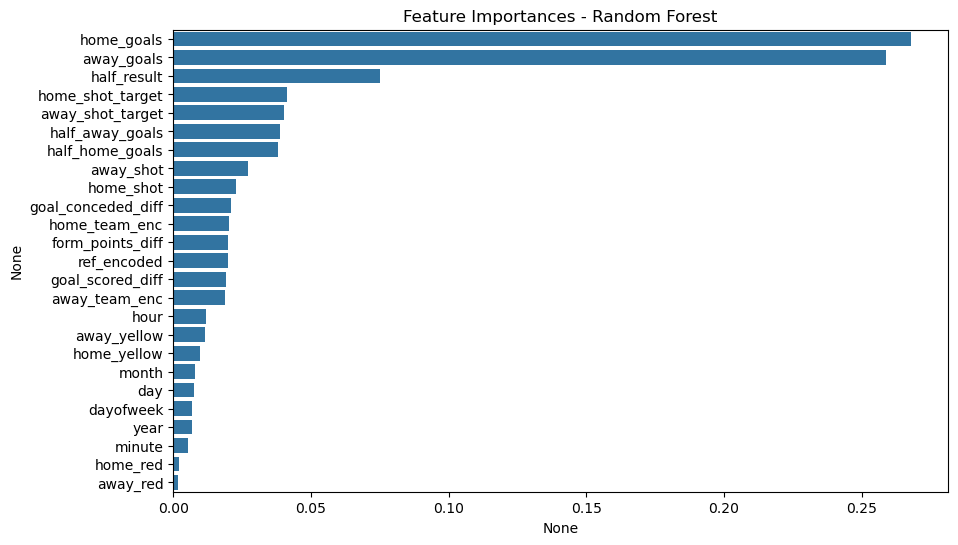

In [19]:
# I. FEATURE IMPORTANCE VISUALIZATION
# =============================
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances - Random Forest")
plt.show()

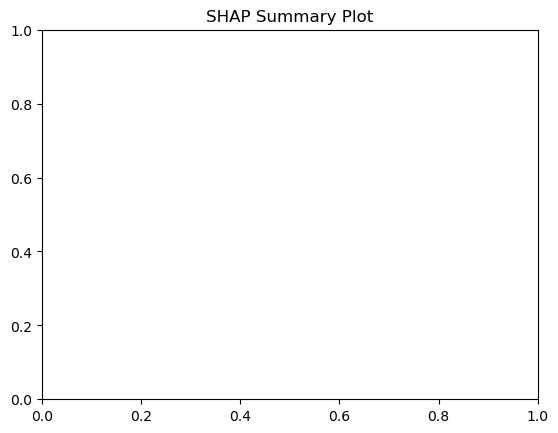

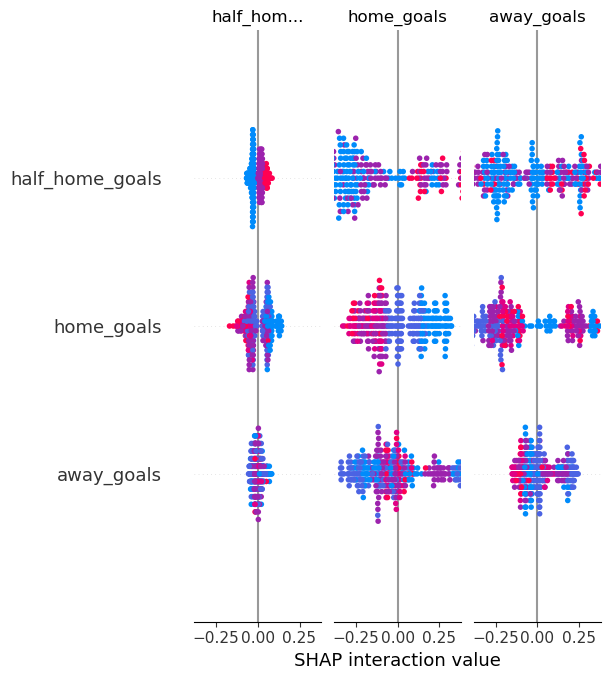

In [20]:
# J. SHAP EXPLAINABILITY
# =============================
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)

plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test, show=True)

In [21]:
# K. SAVE MODEL
# =============================
joblib.dump(best_rf, "best_random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("\n✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [45]:


# =============================
# L. STREAMLIT APP SNIPPET
# =============================

# streamlit_app.py
import streamlit as st
import joblib
import pandas as pd

st.title("⚽ Football Match Result Predictor")

rf = joblib.load("best_random_forest_model.pkl")
scaler = joblib.load("scaler.pkl")

st.sidebar.header("Input Match Features")
form_points_diff = st.sidebar.number_input("Form Points Difference")
goal_scored_diff = st.sidebar.number_input("Goal Scored Difference")
goal_conceded_diff = st.sidebar.number_input("Goal Conceded Difference")
home_team_enc = st.sidebar.number_input("Home Team Code")
away_team_enc = st.sidebar.number_input("Away Team Code")

input_df = pd.DataFrame({
    "form_points_diff": [form_points_diff],
    "goal_scored_diff": [goal_scored_diff],
    "goal_conceded_diff": [goal_conceded_diff],
    "home_team_enc": [home_team_enc],
    "away_team_enc": [away_team_enc]
})

scaled = scaler.transform(input_df)
pred = rf.predict(scaled)[0]
mapping = {2: "🏠 Home Win", 1: "🤝 Draw", 0: "🚩 Away Win"}

st.subheader("Predicted Result:")
st.write(mapping[pred])

print("\n🏁 Football Match Prediction Pipeline completed successfully!")


2025-10-13 19:26:27.890 
  command:

    streamlit run C:\Users\USER\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-13 19:26:28.497 Session state does not function when running a script without `streamlit run`


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- away_goals
- away_red
- away_shot
- away_shot_target
- away_yellow
- ...
